# Побудова і оцінка моделі Дерева прийняття рішень

> **ЗАДАЧА**: [Набір даних про дощі в Австралії](https://kaggle.com/jsphyg/weather-dataset-rattle-package) містить приблизно 10 років щоденних спостережень за погодою з численних австралійських метеостанцій. Ось невеликий зразок з набору даних:
>
> ![](https://i.imgur.com/5QNJvir.png)
>
> Як науковець з даних у Бюро метеорології, вам доручено створити повністю автоматизовану систему, яка може використовувати дані про погоду на сьогодні для певного місця, щоб передбачити, чи буде дощ у цьому місці завтра.
>
>
> ![](https://i.imgur.com/KWfcpcO.png)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# Завантаження даних

In [ ]:
%load_ext autoreload
%autoreload 2

from weather_data_processing import preprocess_data

In [ ]:
raw_df = pd.read_csv('weatherAUS.csv')
data = preprocess_data(raw_df)

In [ ]:
X_train = data['train_X']
train_targets = data['train_y']
X_val = data['val_X']
val_targets = data['val_y']
X_test = data['test_X']
test_targets = data['test_y']

## Навчання та візуалізація дерев рішень

Дерево рішень у загальному розумінні представляє ієрархічну серію if-else рішень:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

Дерево рішень у машинному навчанні працює точно так само, за винятком того, що ми дозволяємо комп'ютеру визначати оптимальну структуру та ієрархію рішень, замість того, щоб вручну створювати критерії.

### Навчання

Ми можемо використовувати `DecisionTreeClassifier` з `sklearn.tree` для навчання дерева рішень.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model = DecisionTreeClassifier(random_state=42)

In [ ]:
%%time
model.fit(X_train, train_targets)

CPU times: user 3.08 s, sys: 66.3 ms, total: 3.14 s
Wall time: 3.17 s


DecisionTreeClassifier(random_state=42)

Оптимальне дерево рішень тепер створено за допомогою навчальних даних.

### Оцінка

Давайте оцінимо дерево рішень за допомогою показника точності (accuracy score).

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
train_preds = model.predict(X_train)

In [ ]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [ ]:
pd.value_counts(train_preds)

No     76192
Yes    21796
Name: count, dtype: int64

Дерево рішень вміє також повертати ймовірності для кожного передбачення.

In [ ]:
train_probs = model.predict_proba(X_train)

In [ ]:
train_probs[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

Здається, що дерево рішень досить впевнене у своїх прогнозах.

Давайте перевіримо точність його прогнозів.

In [ ]:
accuracy_score(train_targets, train_preds)

0.9999795893374699

Точність на навчальній вибірці близька до 100%! Але ми не можемо покладатися лише на точність на навчальній вибірці, ми повинні оцінити модель також на валідаційній вибірці.

Ми можемо зробити прогнози та обчислити точність в один крок, використовуючи `model.score`.

In [ ]:
model.score(X_val, val_targets)

0.7935514073380537

Хоча точність на тренувальному наборі становить 100%, точність на валідаційному наборі складає лише близько 79%, що лише трохи краще, ніж завжди передбачати "Ні".

In [ ]:
val_targets.value_counts() / len(val_targets)

RainTomorrow
No     0.790626
Yes    0.209374
Name: count, dtype: float64

Здається, що модель ідеально вивчила навчальні приклади, але не узагальнює добре на раніше невидимі приклади. Це явище називається "перенавчання" (overfitting), і ми далі спробуємо зменшити його ефект.

### Візуалізація

Ми можемо візуалізувати дерево рішень, _навчене_ на навчальних даних.

In [ ]:
from sklearn.tree import plot_tree, export_text

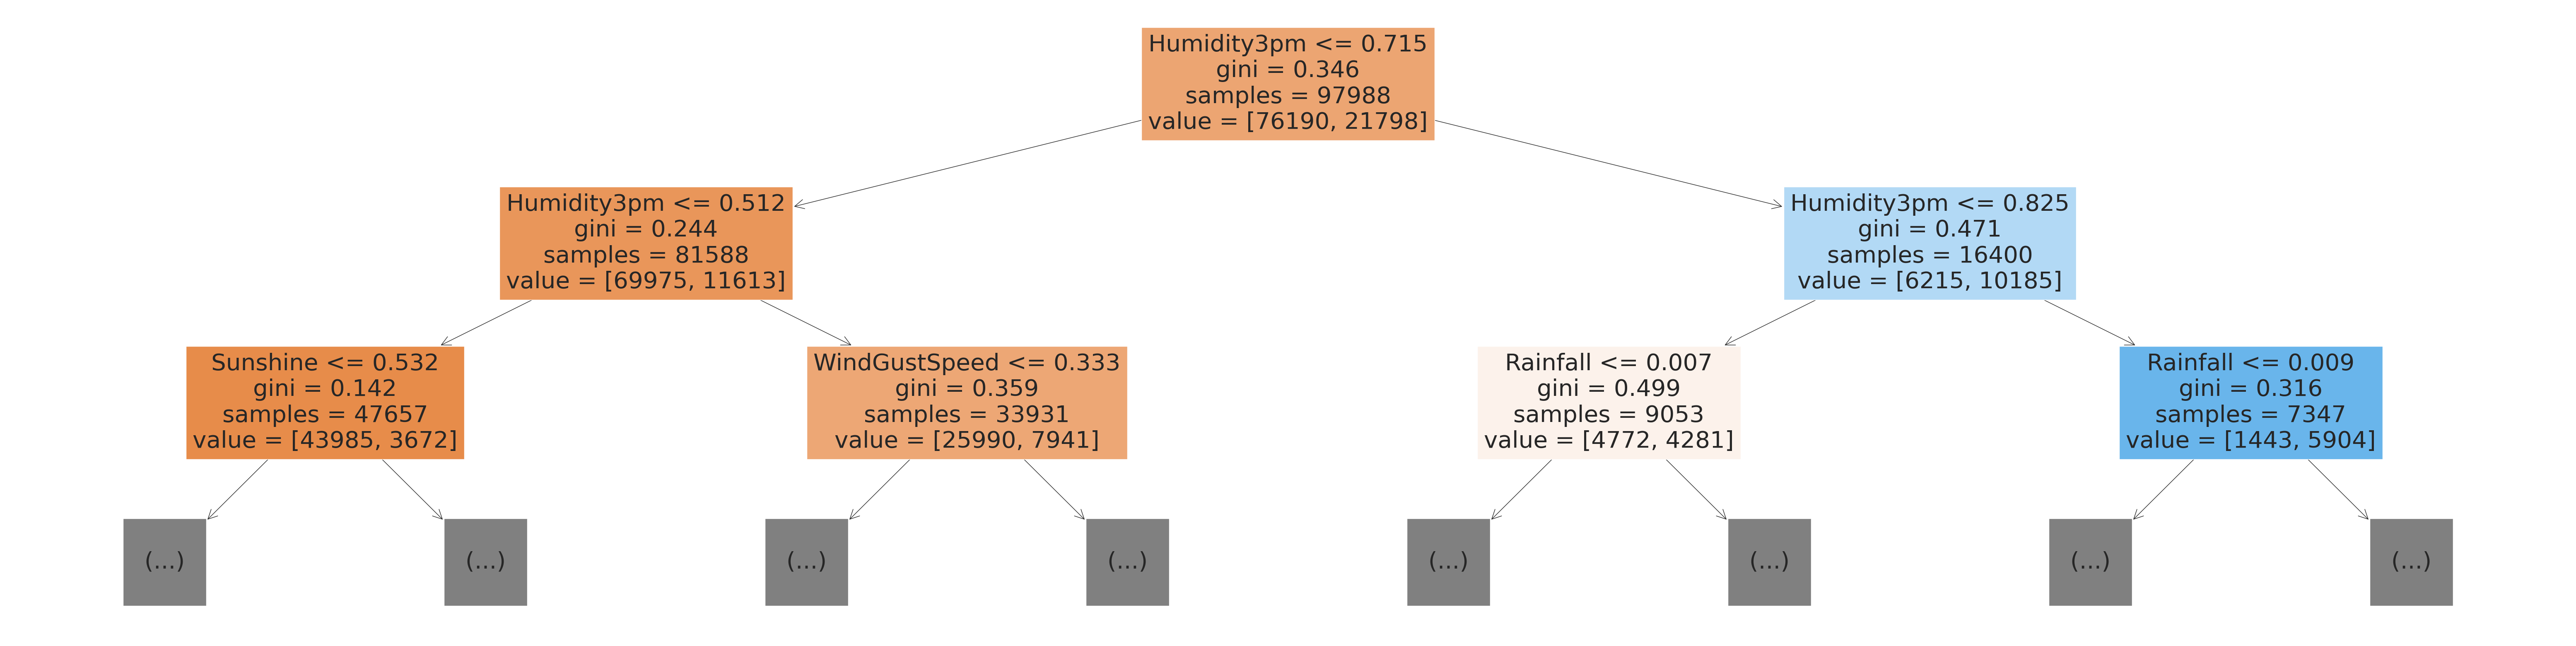

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

Тут ми чітко бачимо, як модель класифікує кожен екземпляр з допомогою серії рішень. Дерево тут обрізане, але слідуючи будь-яким шляхом від кореневого вузла до листка, ви отримаєте "Так" або "Ні".

Зверніть увагу на значення `gini` в кожному боксі. Це функція втрат, яку використовує дерево рішень для визначення, який стовпець слід використовувати для розділення даних і в якому місці слід розділити стовпець. Нижчий індекс Джині вказує на краще розділення. Ідеальне розділення (лише один клас з кожного боку) має індекс Джині, що дорівнює 0.


Давайте перевіримо глибину створеного дерева.

In [ ]:
model.tree_.max_depth

51

Ми також можемо відобразити дерево у вигляді тексту, що може бути легше для розуміння для глибших дерев.

In [ ]:
tree_text = export_text(model, max_depth=2, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- truncated branch of depth 27
|   |   |--- Sunshine >  0.53
|   |   |   |--- truncated branch of depth 37
|   |--- Humidity3pm >  0.51
|   |   |--- WindGustSpeed <= 0.33
|   |   |   |--- truncated branch of depth 49
|   |   |--- WindGustSpeed >  0.33
|   |   |   |--- truncated branch of depth 31
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- truncated branch of depth 31
|   |   |--- Rainfall >  0.01
|   |   |   |--- truncated branch of depth 31
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- truncated branch of depth 26
|   |   |--- Rainfall >  0.01
|   |   |   |--- truncated branch of depth 24



### Важливість ознак

На основі обчислень індексу Джині (gini index), дерево рішень призначає значення "важливості" кожній ознаці. Ці значення можуть бути використані для інтерпретації результатів, наданих деревом рішень.

In [ ]:
model.feature_importances_.round(2)

array([0.04, 0.03, 0.04, 0.02, 0.05, 0.06, 0.03, 0.03, 0.04, 0.28, 0.04,
       0.06, 0.01, 0.02, 0.04, 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

Давайте перетворимо це на DataFrame і візуалізуємо найважливіші ознаки (features).

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.279449
5,WindGustSpeed,0.061233
11,Pressure3pm,0.061085
4,Sunshine,0.046636
2,Rainfall,0.044467
14,Temp9am,0.037482
8,Humidity9am,0.037372
10,Pressure9am,0.037012
0,MinTemp,0.036561
15,Temp3pm,0.032920


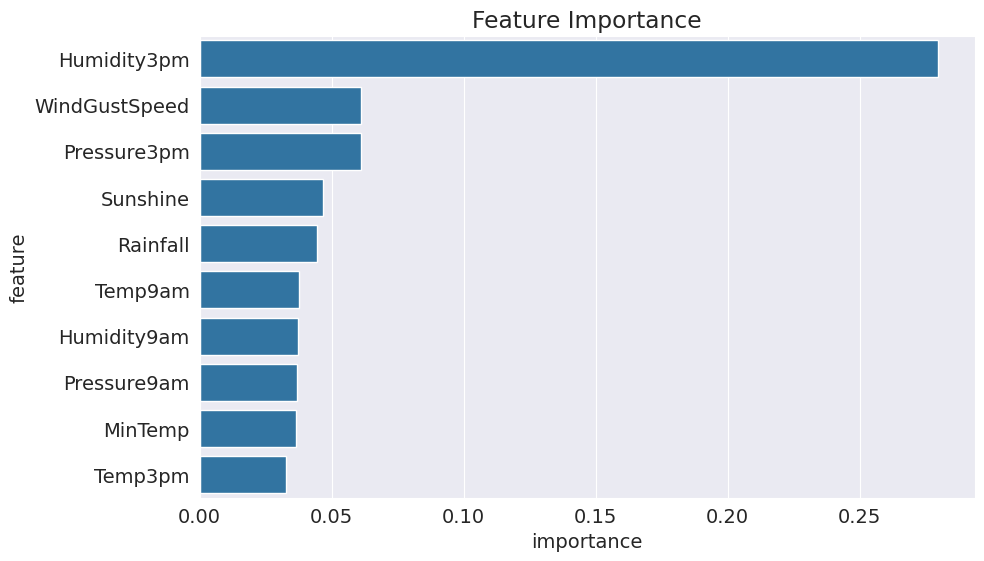

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Налаштування гіперпараметрів та перенавчання

Як ми бачили в попередньому розділі, наш класифікатор на основі дерева рішень запам'ятав усі навчальні приклади, що призвело до 100% точності на навчальній вибірці, тоді як точність на валідаційній вибірці була лише трохи кращою за базову модель. Це явище називається перенавчанням (overfitting), і в цьому розділі ми розглянемо деякі стратегії для зменшення перенавчання дерева прийняття рішень.

`DecisionTreeClassifier` приймає кілька аргументів, деякі з яких можна змінити для зменшення перенавчання.

In [ ]:
?DecisionTreeClassifier

Ці аргументи називаються гіперпараметрами (hyperparameters), тому що їх потрібно налаштовувати вручну (на відміну від параметрів у моделі, які _вивчаються_ з даних). Ми розглянемо кілька гіперпараметрів:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

Зменшуючи максимальну глибину дерева рішень, ми можемо запобігти запам'ятовуванню деревом всіх навчальних прикладів, що може призвести до кращої узагальненості.

In [ ]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [ ]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

Ми можемо обчислити точність (accuracy) моделі на навчальних та валідаційних наборах даних за допомогою `model.score`.

In [ ]:
model.score(X_train, train_targets)

0.8315916234640977

In [ ]:
model.score(X_val, val_targets)

0.8348060155655685

Чудово, хоча точність моделі на тренувальних даних знизилася, точність моделі на валідаційних даних значно зросла.

In [ ]:
model.classes_

array(['No', 'Yes'], dtype=object)

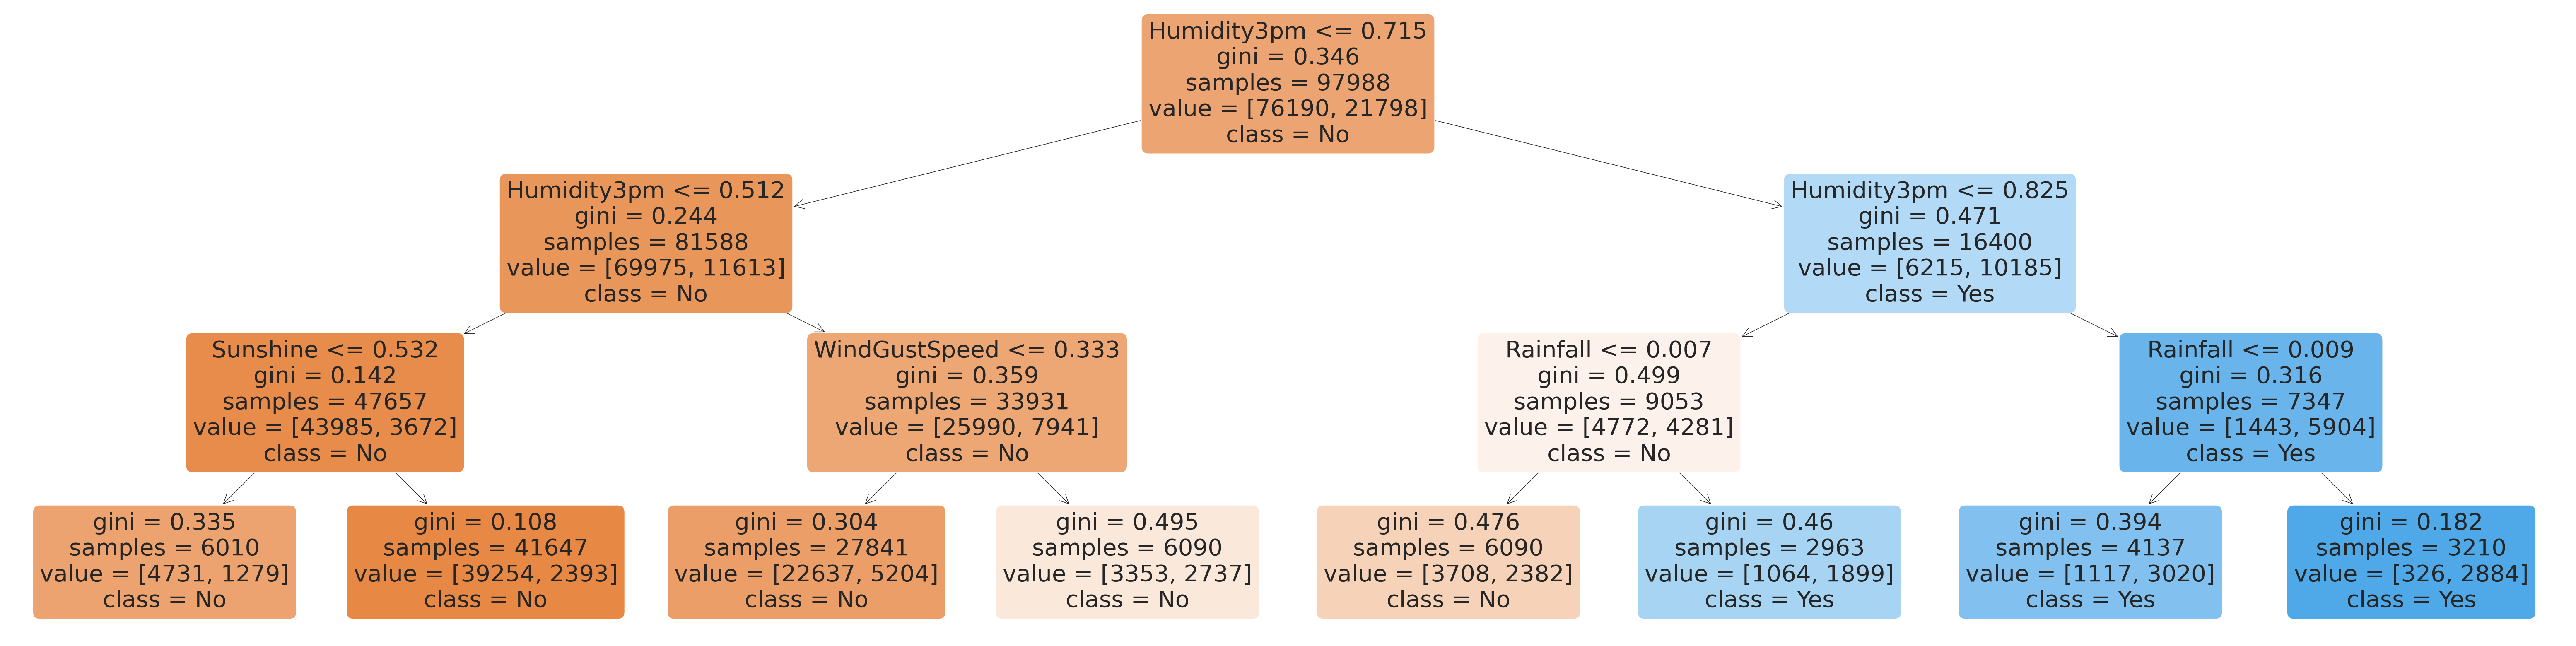

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

> **ВПРАВА**: Уважно вивчіть діаграму дерева рішень і перевірте, чи чітко розумієте, що означають кожен з термінів `gini`, `samples`, `value` та `class`. Кожен з цих елементів ми вже обговорювали раніше.

In [ ]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- class: No
|   |   |--- Sunshine >  0.53
|   |   |   |--- class: No
|   |--- Humidity3pm >  0.51
|   |   |--- WindGustSpeed <= 0.33
|   |   |   |--- class: No
|   |   |--- WindGustSpeed >  0.33
|   |   |   |--- class: No
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: No
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: Yes
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes



Давайте експериментувати з різними глибинами, використовуючи допоміжну функцію.

In [ ]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_error = 1 - model.score(X_train, train_targets)
    val_error = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_error, 'Validation Error': val_error}

In [ ]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

CPU times: user 41.8 s, sys: 1.24 s, total: 43 s
Wall time: 44.9 s


In [ ]:
errors_df.style.background_gradient(subset='Validation Error', cmap='Blues_r')

,Max Depth,Training Error,Validation Error
0,1,0.181941,0.176488
1,2,0.176930,0.170695
2,3,0.168408,0.165194
3,4,0.162153,0.161624
4,5,0.157244,0.158113
5,6,0.153131,0.155831
6,7,0.149059,0.154602
7,8,0.144814,0.153842
8,9,0.139384,0.154427
9,10,0.131792,0.155188


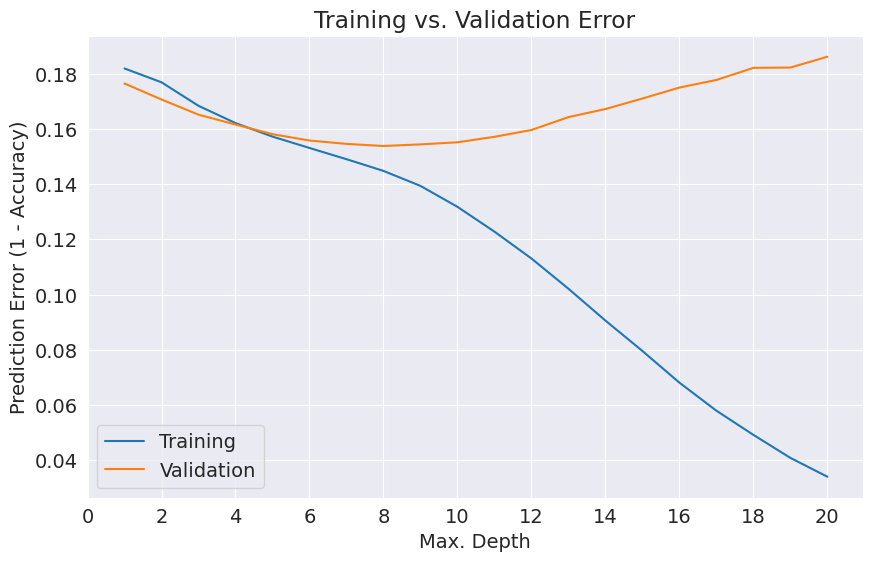

In [ ]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

Це поширений шаблон, який ви побачите у всіх алгоритмах машинного навчання:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Часто вам потрібно ретельно налаштовувати гіперпараметри, щоб знайти оптимальну відповідність. У наведеному вище випадку, здається, що максимальна глибина 7 призводить до найнижчої помилки валідації.

In [ ]:
model = DecisionTreeClassifier(max_depth=8, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8461583474749839

### `max_leaf_nodes`

Ще один спосіб контролювати розмір складності дерева рішень - обмежити кількість листових вузлів. Це дозволяє гілкам дерева мати різну глибину.

In [ ]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [ ]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [ ]:
model.score(X_train, train_targets)

0.852696248520227

In [ ]:
model.score(X_val, val_targets)

0.8471531394464276

In [ ]:
model.tree_.max_depth

11

Зверніть увагу, що модель змогла досягти більшої глибини 12 для певних шляхів, зберігаючи інші шляхи коротшими.

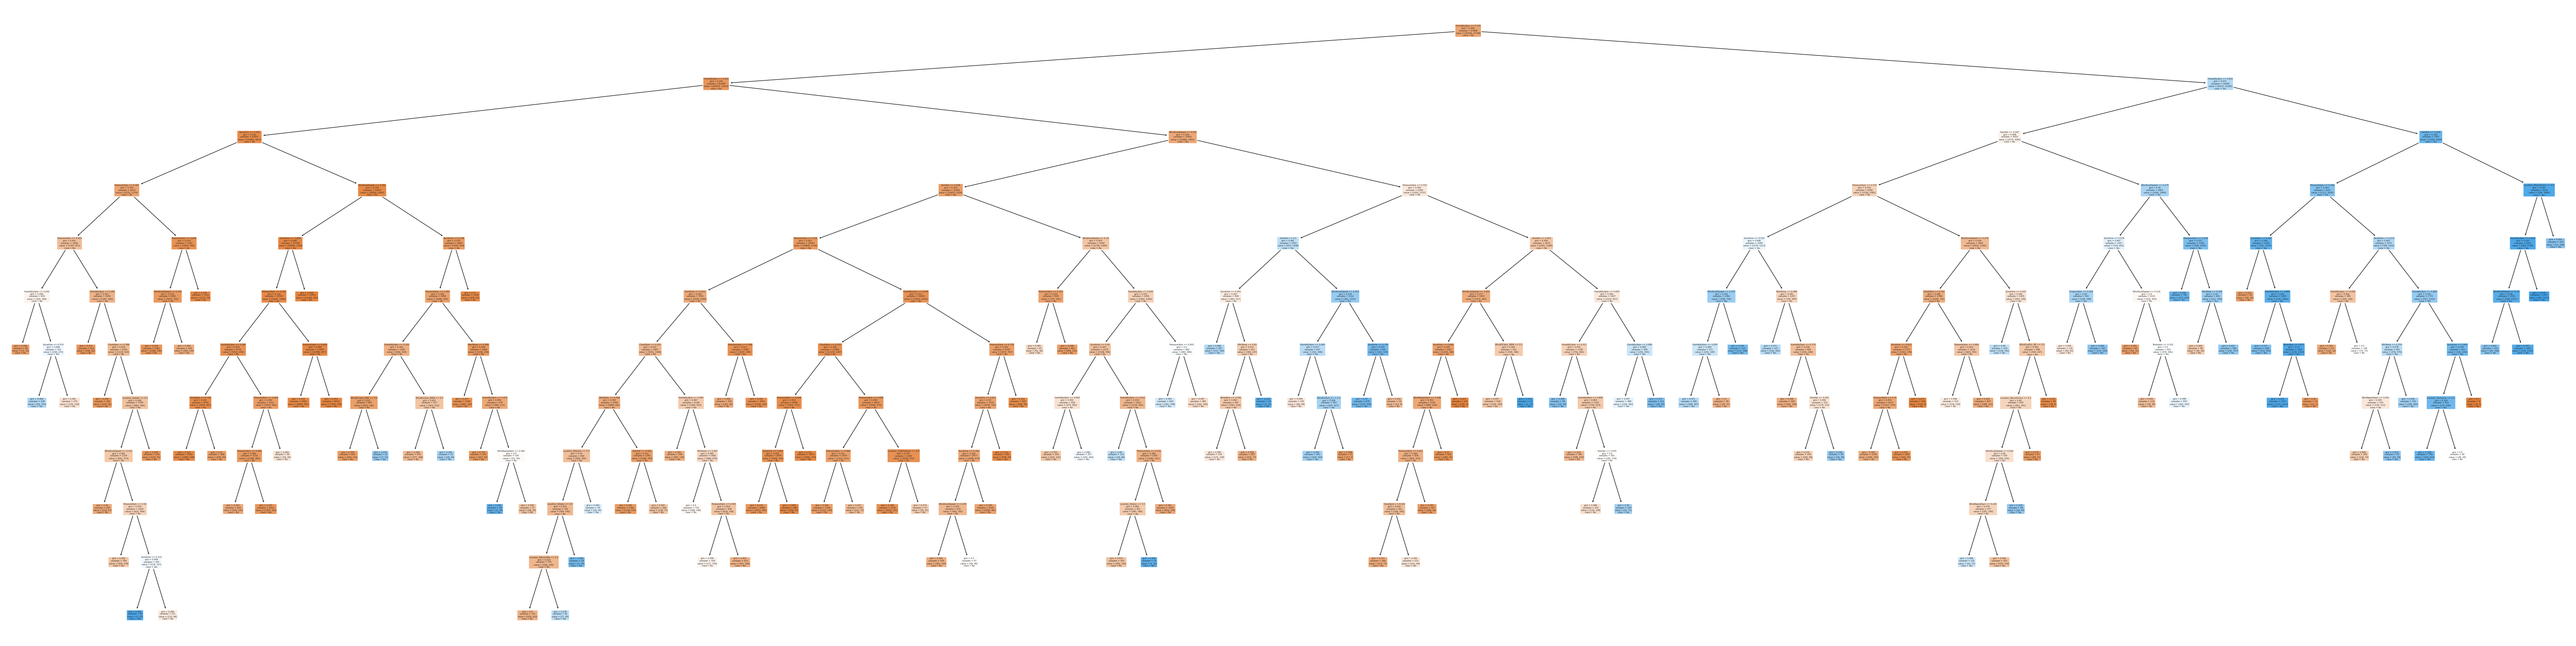

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [ ]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- Pressure3pm <= 0.57
|   |   |   |   |--- Pressure3pm <= 0.42
|   |   |   |   |   |--- Humidity3pm <= 0.24
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.24
|   |   |   |   |   |   |--- Sunshine <= 0.37
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.37
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |--- Pressure3pm >  0.42
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Cloud3pm <= 0.39
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |--- Cloud3pm >  0.39
|   |   |   |   |   |   |   |--- Location_Hobart <= 0.50
|   |   |   |   |   |   |   |   |--- WindGustSpeed <= 0.23
|   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- WindGustSpeed >  0.23

> **ВПРАВА**: Знайдіть комбінацію `max_depth` і `max_leaf_nodes`, яка призводить до найвищої точності валідації.

> **ВПРАВА**: Досліджуйте та експериментуйте з іншими аргументами `DecisionTree`. Зверніться до документації для деталей: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# Prunning

Більш просунутий метод (але менш поширений метод) для зменшення перенавчання в дереві рішень відомий як обрізка складності вартості (cost-complexity pruning).

Мінімальна вартісна складність обрізки рекурсивно знаходить вузол з "найслабшою ланкою". Найслабша ланка характеризується ефективним альфа, де вузли з найменшим ефективним альфа обрізаються першими. Щоб отримати уявлення про те, які значення `ccp_alpha` можуть бути доречними, `scikit-learn` надає метод `DecisionTreeClassifier.cost_complexity_pruning_path`, який повертає ефективні альфа та відповідні загальні домішки листків на кожному етапі процесу обрізки. Зі збільшенням альфа, більше частин дерева обрізається, що збільшує загальну домішку його листків.

Дізнайтеся більше про це тут: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html .

In [ ]:
model = DecisionTreeClassifier(random_state=42)
path = model.cost_complexity_pruning_path(X_train, train_targets)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

У наступному графіку максимальне значення ефективного альфа видалене, оскільки це тривіальне дерево з лише одним вузлом.

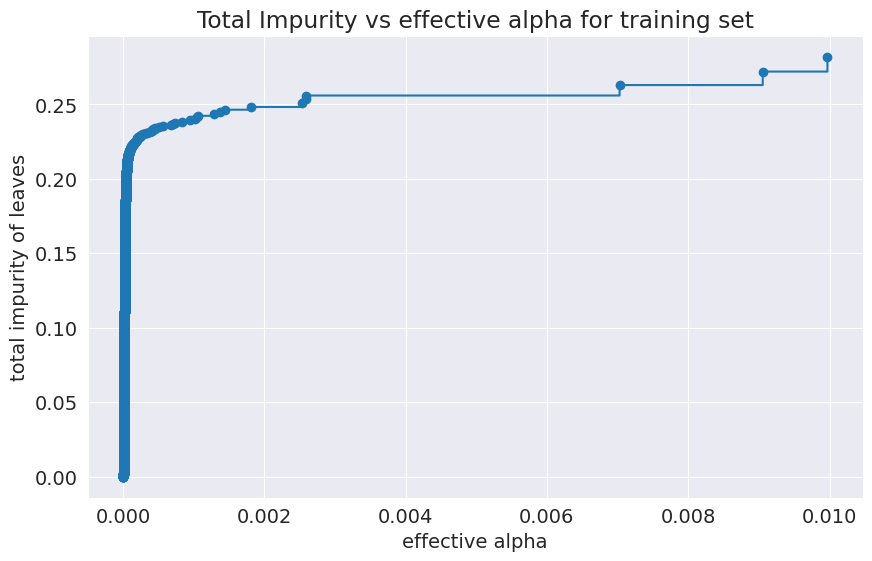

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");

In [ ]:
len(ccp_alphas)

4965

In [ ]:
models = []
for ccp_alpha in ccp_alphas[-10:]:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    model.fit(X_train, train_targets)
    models.append(model)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        models[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.06386754899460867


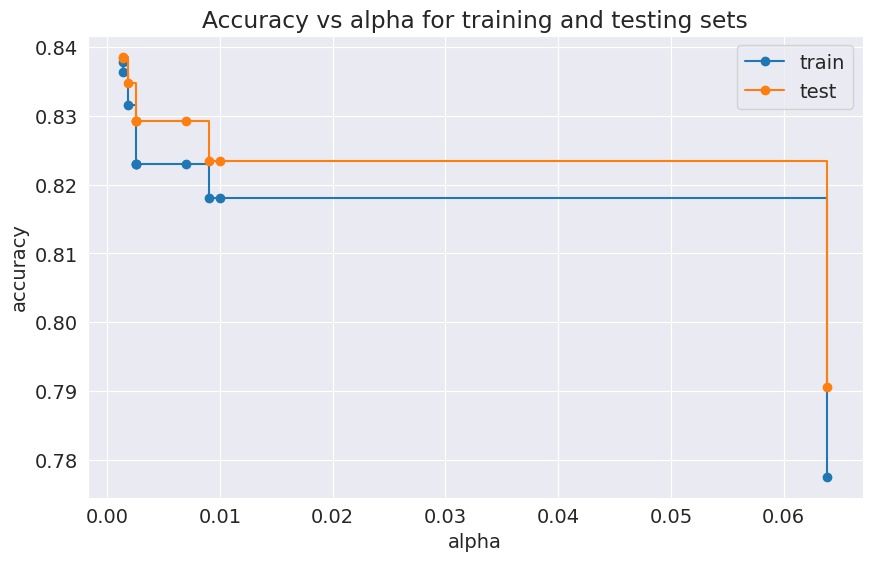

In [ ]:
train_scores = [model.score(X_train, train_targets) for model in models]
val_scores = [model.score(X_val, val_targets) for model in models]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[-10:], train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[-10:], val_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[-20])
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [ ]:
model.tree_.max_depth

6

In [ ]:
model.score(X_train, train_targets)

0.8413785361472833

In [ ]:
model.score(X_val, val_targets)

0.8420621452396279